In [1]:
# default_exp unsupervised
# default_cls_lvl 2

# Chapter 9. Unsupervised Learning
>

- Although most of the applications of machine learning algorithms today are based on supervised learning, The vast majority of the available data is **unlabeled**.
- We have the input $X$, but we don't have the labels $y$.
- Yann LeCun: "If intelligence was a cake, **Unsupervised Learning** would be the **cake**, **supervised learning** would be the **icing** on the cake, and **reinforcement learning** would be the **cherry** on the cake."
- In this chapter we will look at a few unsupervised learning tasks and algorithms:
    - Clustering: the goal is to group similar instances together into clusters.
        - Clustering is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning,..
    - Anomaly Detection: This is the task of estimating the probability density function of the random process that generated the dataset.
        - Instances located in very low-density regions are likley to be anomalies.

## Clustering

- Clustering: identifying groups containing similar objects.
- Consider the example of unsupervised clustering the Iris dataset
    - If we remove its labels, we can't use classification algorithms.
    - Unsupervised Learning Clustering make use of all available features to located clusters and assign all instances to one of them.
        - Using a Gaussian Mixture Model, only 5/150 are assigned to the wrong cluster.
- Clustering is used in:
    - Customer Segmentation
    - Data Analysis
        - It might be useful to cluster the instance and analyse each separately.
- Dimensionality Reduction
    - By replacing the features with each instance's affinity to each cluster.
- Anomaly Detection
    - Any instance that have low affinity to all clusters is likely to be an outlier.
- Semi-supervised Learning
    - If you have a few labels, you can perform clustering and propagate the available labels to other instances within the clusters.
- Search Engines
    - Image similarity search: clustering available images & when a new item is provided by the user, cluster it using the same algorithm and return the top N centered items.
- To segment an image
    - By clustering pixels according to their color, then replacing pixel colors with the mean of its cluster.
- There are different types of clustering algorithms and there isn't a universal definition of what a cluster is.
- In this section, we will look at two widely used unsupervised learning clustering algorithms, the first one is `KMeans` and the second is `DBSCAN`.

### K-Means

- Let's start with makes some data:

In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt

In [3]:
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=[0.5, 0.5, 0.5, 1, 1])

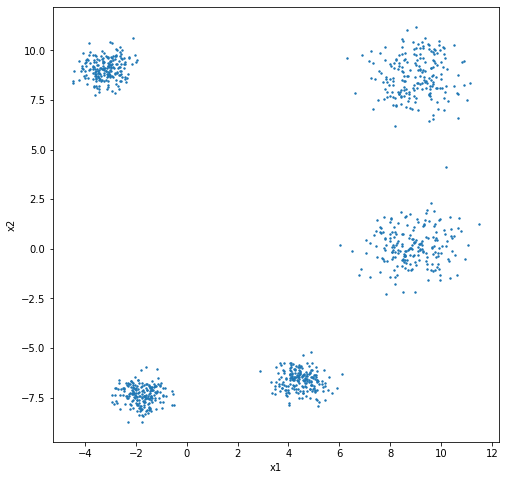

In [4]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

- Let's train a k-means clusterer on this dataset.

In [5]:
from sklearn.cluster import KMeans

In [6]:
k = 5

In [7]:
kmeans = KMeans(n_clusters=k)

In [8]:
y_pred = kmeans.fit_predict(X)

- Note that you have to specify the number of clusters to be found.


In [9]:
y_pred is kmeans.labels_

True

- We can also take a look at the five centroids the algorithm found:

In [10]:
kmeans.cluster_centers_

array([[ 8.88261718,  0.11473421],
       [-1.77506507, -7.3687464 ],
       [-3.20017547,  9.07503905],
       [ 9.00425282,  8.70899118],
       [ 4.47018117, -6.62640481]])

- We can easily predict the cluster of new instances:

In [11]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])

In [12]:
kmeans.predict(X_new)

array([2, 0, 2, 2], dtype=int32)

- By plotting the algorithm's decision boundaries, we get a Voronoi tesselation:

In [13]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [14]:
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

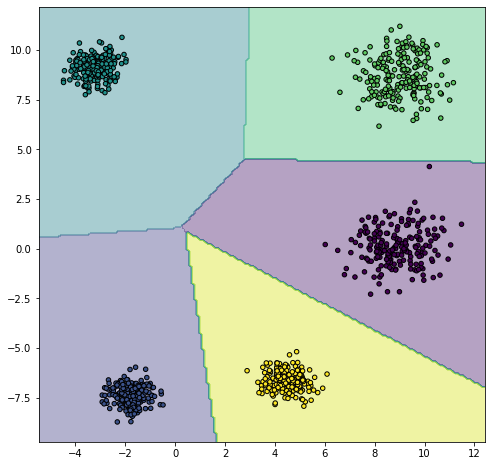

In [15]:
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20, edgecolor='k')
plt.show()

- The vast majority of the instances were clearly assigned to their original cluster.
- All KMeans cares about is the distance between instances and the centroids.
- Instead of assigning each instance to a cluster (hard clustering) it's better to give a per-instance cluster score (soft clustering).
    - The score can be the distance between the instance and the centroids.
        - This can also be a good dimensionality reduction technique.
- In `sklearn`, the `transform` method measures the distance between each instance and the centroids.

In [16]:
kmeans.transform(X_new)

array([[ 9.08047989,  9.5354216 ,  7.76513365, 11.22885263,  9.71583139],
       [ 6.17733049, 10.51544842,  9.40735635,  9.00342238,  8.75078811],
       [12.22789228, 10.44085089,  6.0783361 , 13.29265459, 12.184879  ],
       [12.11965692,  9.94447691,  6.57808549, 13.514942  , 11.79384888]])

### `KMeans` Algorithm

- How does the algorithm work?
- Suppose you were given the centroids.
- You could easily label all the instances in the dataset by assigning each of them to the cluster with the closest centroid.
- Conversely, if you were given all the instance labels, you could easily locate all the centroids by computing the mean of the instances within each cluster.
- But you are given neither the labels nor the centroids, so how can you proceed?
- **By just picking centroids randomly**
    - By picking $k$ instance at random and using their locations as centroids
- **Then label the instances, update the centroids, label the instances, update the centroids, and so on until the centroids stop moving**.
- **The algorithm is guaranteed to converge in a finite number of steps (usually very small) & It will not oscillate forever**.
- The computational complexity of the algorithm is generally linear with regard to the number of instances $m$, the number of clusters $k$, and the number of dimensions $n$.
    - However, this is only true when the data is comprised of clusters.
    - It has an expenential complexity if the instances are not in structurly in clusters.
- `KMeans` is generally one of the fastest clustering algorithms.
- Even though the algorithm is guaranteed to converge, it may not converge to the right solution.
    - It may converge to a local optimum.
    - **It all depends on the initialization step**.
- Let's look at how we can mitigate this:

### Centroid Initialization Methods

- If you happen to know approximately where the centroids should be (using `DBSCAN` for example), then you can initialize `KMeans` properly:

In [17]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])

In [18]:
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)

- Another solution is to **run the algorithm multiple times with different random initialization and keep the best solution, it is controlled by the `n_init` hyperparameter.
    - `Scikit-learn` will keep the best solution for you by running the algorithm `n_init` times.
- But to know what signifies the word `best`, it uses a performance metric, that metric is called the `inretia`
    - **Which is the mean squared distance between each centroid and its corresponding instances**.
- An important improvement to the `KMeans` algorithm is `K-Means++` which introduces a smarter initialization strategy that tend to select centroids that are distant from one another.
    - This improvement makes the algorithm much less likely to converge to a sub-optimal solution.
    - The extra compute is well worth it since it reduces the needed `n_init` value.
- Here is the `K-Means++` Initialization Steps:
    1. Take 1 centroid $c^{(1)}$ taken uniformely-randomly from the dataset.
    2. Take a new centroid $c^{(i)}$, choosing an instance $x^{(i)}$ with probability $\frac{D(x^{(i)})^2}{\sum_{j=1}^{m}D(x^{(j)})^2}$
        - $D(x^{(i)})$ is the distance between $x^{(i)}$ and the **closest** centroid that was already chosen.
    3. Repeat the previous step until all $k$ centroids have been chosen.

### Accelerated `K-Means` and `Mini-Batch K-Means`

- Another [important improvement](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) to the K-means algorithm was proposed and it considerably accelerated the algorithm by avoiding many unecessary distance calculations.
- This was achieved by exploiting the triangle inequality.
    - The Norm of a Straight line is always the shortest distance between two points.
- And by keeping track of lower and upper bounds for distances between instances and centroids.
- This Improvement is also implemented within `sklearn`.
- Another [paper](http://www.ra.ethz.ch/CDstore/www2010/www/p1177.pdf) proposed using mini-batches instead of the whole dataset for each iteration.
- This **Speeds up** the algorithm typically by a factor of three or four and make it possible to cluster huge datasets that don't fit into memory.
- Let's use it in `sklearn`:

In [19]:
from sklearn.cluster import MiniBatchKMeans

In [20]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5)

In [21]:
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

- If our dataset can't fit in memory, we can use `memmap` with the `partial_fit()` method.
- The advantage of using `MiniBtachKMeans` becomes significant when we choose a big `k` for clusters.
    - Batching becomes much faster and the performance stays roughly the same:

<div style="text-align:center">
    <img style="width:50%" src="static/imgs/inretia_speed.png">
</div>

### Finding the Optimal Number of Clusters

- You might be thinking that we can just pick the model with the lowest inretia.
    - Because increasing `k` will always give you a lower inretia.
- Let's visualize inretia as a function of `k`:

<div style="text-align:center">
    <img style="width:50%" src="static/imgs/k_to_inretia.png">
</div>

- As you may see, the inretia drops big when we go from $3$ to $4$ but then it decreases much more slowly we continue to increase $k$.
- This curve has roughly the shape of an arm and there is an elbow at $k=4$. So we pick $4$.
    - This method of choosing the optimal number of clusters is rather coarse.
- A more precise and computationally expensive appraoch is to use the **silhouette score**, which is the mean silhouette coefficient over all the instances.
- An instance silhouette score is equal to $\frac{b-a}{max(a,b)} \in [-1,1]$
    - $a$: mean distance to other instances in the same cluster.
    - $b$: mean distance to instances in the next closest cluster.
    - $+1$ means the instance is well inside its own cluster and far from other clusters.
    - $0$ means the instance is sitting on the edge between two clusters.
    - $-1$ means the instance may just be on the wrong cluster.
- The silhouette score measure a cluster **density** score.
- Let's compute it using `sklearn`:

In [22]:
from sklearn.metrics import silhouette_score

In [23]:
silhouette_score(X, minibatch_kmeans.labels_)

0.8434440195340372

- Let's compare the silhouette score for different number of clusters:

In [24]:
scores = list()
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    scores.append(silhouette_score(X, kmeans.labels_))
    del(kmeans)

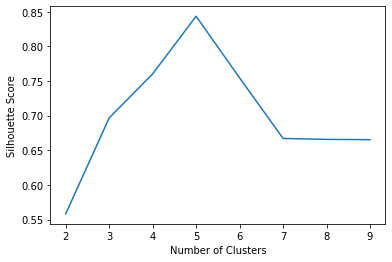

In [25]:
plt.plot(list(range(2, 10)), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

- This is a better visualization because it showcases the importance of small number of clusters.
- An even more informative visualization is obtained when you plot every instance's silhouette coefficient, sorted by.. 
    - the cluster they are assigned to
    - the value of the coefficient
- The dashed line indicates the mean silhouette coefficient:

<div style="text-align:center">
    <img style="width:50%" src="static/imgs/silhouette_diagram.png">
</div>

- When most of the instances in a cluster have a lower coefficient than this score.
    - Then the cluster is rather bad since this means its instances are much too close to other clusters.
- `4` and `5` look fine and it seems like a good idea to use $k=5$ to get clusters of similar sizes.

### Limits of K-Means

- `KMeans` is not perfect.
- It is necessary to run the algorithm multiple times to avoid suboptimal solutions.
- You need to specify the number of clusters.
- `KMeans` doesn't behave very well when the clusters have varying sizes, different densities, or non-spherical shapes.
- Depending on the data, different clustering algorithms may perform better.
    - Like `DBSCAN` or `Gaussian Mixtures`.
- Scaling the inputs is also a must with `KMeans`.
- Let's look at a few ways we can beenfit from clustering:

### Using Clustering for Image Segmentation

- Image segmentation is the task of partitioning an image into multiple segments.
- All pixels that are part of the same object type get assigned to the same segment.
- In *instance segmentation*, all pixels that are part of the same object get assigned to the same segment.
- The state of the art in semantic or instance segmentation today is achieved using complex architectures based on convolutional neural networks.
- Here, we are going to do something much simpler, **color segmentation**.
    - We will simply assign pixels to the same segment if they have similar color.
    - Application: If you want to assess forest cover in a satellite image, color segmentation may be enough.
- Let's do it:

In [26]:
from matplotlib.image import imread
import os

In [27]:
image = imread(fname=os.path.join("static", "imgs", "butterfly.jpg"))

In [28]:
image.shape

(850, 1280, 3)

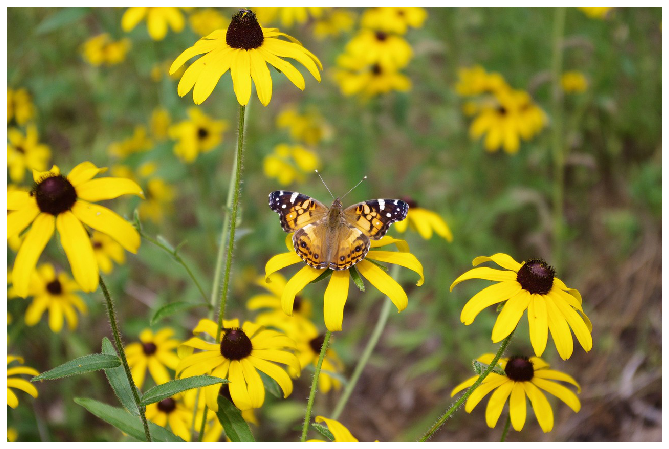

In [29]:
plt.figure(figsize=(12, 8))
plt.imshow(image.astype(int))
plt.axis('off')
plt.show()

In [30]:
X = image.reshape((-1, 3))
X.shape

(1088000, 3)

In [31]:
kmeans = KMeans(n_clusters=8).fit(X)

In [32]:
segmented_image = kmeans.cluster_centers_[kmeans.labels_]

In [33]:
segmented_image = segmented_image.reshape(image.shape)

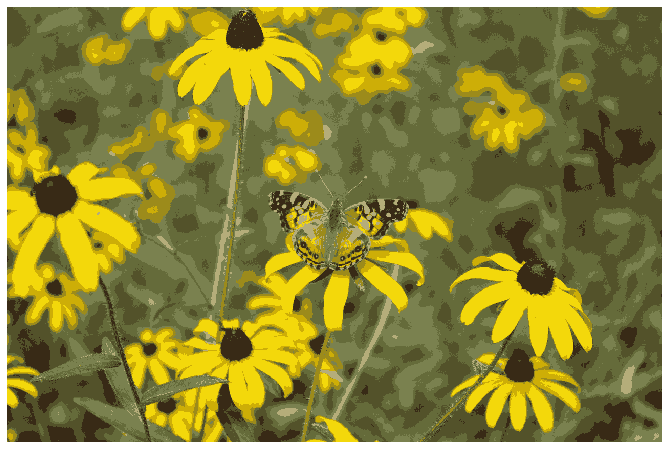

In [34]:
plt.figure(figsize=(12, 8))
plt.imshow(segmented_image.astype(int))
plt.axis('off')
plt.show()

- *Note*: far away points may correspond to the same cluster because `KMeans` is not aware of spatial positioning, its input points correspond to 3D RGB points.
    - It clusters them according to how much they're close to each other.
- Now let's take a look at using clustering for **preprocessing**:

### Using Clustering for Preprocessing

- Clustering can be an efficient approach to dimensionality reduction
- In particular, as a preprocessing step before a supervised learning algorithm.
- As an example of using clustering for dimensionality reduction, let's tackle the small-digits dataset:

In [35]:
from sklearn.datasets import load_digits

In [36]:
X, y = load_digits(return_X_y=True)
X.shape, y.shape

((1797, 64), (1797,))

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1347, 64), (1347,), (450, 64), (450,))

- Next, fit a logistic regression model:

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [41]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
log_reg.score(X_test, y_test)

0.9466666666666667

- That's our baseline, $94.2%$ accuracy.
- We we create a pipeline that will first cluster the training set into `50` clusters and **replace the images with their distances to these 50 clusters**, then apply a logistic regression model:

In [43]:
from sklearn.pipeline import Pipeline

In [44]:
pipeline = Pipeline(steps=[
    ("kmeans", KMeans(n_clusters=50)),
    ("log_reg", LogisticRegression(solver='liblinear', multi_class='auto'))
])

In [45]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [46]:
pipeline.score(X_test, y_test)

0.96

- I think that by reducing the dimensionality of the Input, we removed much of the noise and patterns were easier to get recognized by the logistic regressor.
- But we choose the number of clusters arbitrarily, we can surely do better.
- We can use `GridSearchCV` to find the optimal number of clusters based on the final scoring by Logistic Regression:

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
param_dict = dict(kmeans__n_clusters=range(75,125))

In [49]:
grid_clf = GridSearchCV(pipeline, param_dict, cv=3, verbose=2)

In [50]:
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] kmeans__n_clusters=75 ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ kmeans__n_clusters=75, total=   0.6s
[CV] kmeans__n_clusters=75 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ............................ kmeans__n_clusters=75, total=   0.7s
[CV] kmeans__n_clusters=75 ...........................................
[CV] ............................ kmeans__n_clusters=75, total=   0.6s
[CV] kmeans__n_clusters=76 ...........................................
[CV] ............................ kmeans__n_clusters=76, total=   0.7s
[CV] kmeans__n_clusters=76 ...........................................
[CV] ............................ kmeans__n_clusters=76, total=   0.8s
[CV] kmeans__n_clusters=76 ...........................................
[CV] ............................ kmeans__n_clusters=76, total=   0.7s
[CV] kmeans__n_clusters=77 ...........................................
[CV] ............................ kmeans__n_clusters=77, total=   0.6s
[CV] kmeans__n_clusters=77 ...........................................
[CV] ............................ kmeans__n_clusters=77, total=   0.6s
[CV] kmeans__n_clusters=77 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=None, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
    

In [51]:
grid_clf.best_params_

{'kmeans__n_clusters': 124}

In [52]:
grid_clf.score(X_test, y_test)

0.9733333333333334

- With **`k=99`**, we got a significant accuracy boost just by reducing the dimensionality of the dataset with unsupervised clustering before training a regressor.

### Using Clustering for Semi-Supervised Learning

- It's when we have plenty of unlabeled instances and very few labeled instances.
- Let's train a logistic regression model on a sample of 50 labeled instances from the digits dataset:

In [53]:
n_labeled = 50 

In [54]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [55]:
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
log_reg.score(X_test, y_test)

0.8444444444444444

- It should come as no surprise that this is much lower than earlier becasue we only used 50 training points.
- Let's cluster the training set into 50 clusters.
- Then for each cluster, let's find the image closest to the centroid.
- We will call these images the representative images:

In [57]:
k = 50

In [58]:
kmeans = KMeans(n_clusters=k)

In [59]:
X_digits_dist = kmeans.fit_transform(X_train)

In [60]:
import numpy as np

In [61]:
representative_digit_idx = np.argmin(X_digits_dist, axis=0)

In [62]:
X_representative_digits = X_train[representative_digit_idx]

- Let's look at each image and manually label it:

In [63]:
y_representative_digits = y_train[representative_digit_idx].copy()

- Now we have a dataset with just $50$ labeled instances, but instead of being random instances, each of them is a representative image of its cluster.
- Let's see if the performance is any better:

In [64]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [65]:
log_reg.fit(X_representative_digits, y_representative_digits)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
log_reg.score(X_test, y_test)

0.8822222222222222

- We've made a big jump in performance even though we are still training using the same number of data points.
- We could only do this by **manually labelling representative instances**
    - We get representative instances by running **unsupervised clustering** (k clusters) and taking the k instances closest to each of centroids.
- But what if we propagated the labels to all the other instances in the same cluster, this is called **label propagation**:

In [67]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)

In [68]:
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

- Let's train the model and look at its performance:

In [69]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [70]:
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
log_reg.score(X_test, y_test)

0.94

- We've got a reasonable boost but nothing really astounding.
- The problem is that we propagared each representative instances label to **all the instances** in the same cluster, **including the instances located close to the cluster boundaries**.
    - Which are more likely to be **mislabeled**.
- Let's see what happens if we only propagate the labels to the $20%$ of the instances that are closest to the centroids:

In [72]:
percentile_closest = 20.

In [73]:
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

In [74]:
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [75]:
partially_propagated = (X_cluster_dist != -1)

In [76]:
X_train_partially_propagated = X_train[partially_propagated]

In [77]:
y_train_partially_propagated = y_train[partially_propagated]

- Now let's train the model on this partially propagated dataset:

In [78]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [79]:
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
log_reg.score(X_test, y_test)

0.9133333333333333

- Active Learning
    - To continue improving your model and your training set, the next step could be to do a few rounds of **active learning**.
        - which is when a human expert interacts with the learning algorithm
        - providing labels for specific instances when the algorithm requests them.
    - There are many strategies for active learning
        - One of the most common ones is called uncertainty sampling.
    - Here is how **uncertainty sampling** works:
        1. The model is trained on the labeled instances gathered so far. Model is used to make predictions on all of the unlabeled instances.
        2. The instances where the most is most uncertain are given to the expert to be labeled.
        3. You iterate this process until the increase in performance doesn't worth the effort of manual labeling.
    - Other strategies include labeling the instances that would result in the largest **model change**, or the largest drop in **validation error**, or instances that different models disagree on.
- Before moving to gaussian mixture models, we will take a look at `DBSCAN` which uses **local density estimation** to identify clusters of arbitrary shapes. 

### DBSCAN

- This algorithm defines clusters as **continuous regions of high density**, here is how it works:
    - For each instance:
        - We count how many instances are located within a small distance $\epsilon$ from it.
            - This region is called the $\epsilon$-neighborhood.
        - If an instance has **$\ge$min_samples** instances in its $\epsilon$-neighborhood, then it is considered a **core instance**.
            - Core instances are those that are located in dense regions.
    - All instances in the neighborhood of a core instance **belong to the same cluster**.
        - This neighborhood may include other core instances.
        - Therefore, **a long sequence of neighboring core instances forms a single cluster**.
    - Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.
- **This algorithm works well if all the clsuters are dense enough and if they are well separated by low-density regions**.
- Let's use it:

In [81]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

In [82]:
X, y = make_moons(n_samples=1000, noise=0.05)
X.shape, y.shape

((1000, 2), (1000,))

In [83]:
dbscan = DBSCAN(eps=0.05, min_samples=5)

In [84]:
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

- We access the labels as follows:

In [85]:
dbscan.labels_[:5]

array([0, 1, 2, 2, 0])

- instances with labels `-1` are considered anomalies by the algorithm.
- We can also access core instances like this:

In [86]:
len(dbscan.core_sample_indices_)

790

In [87]:
# actual core instances coords
dbscan.components_

array([[ 2.02001791,  0.39874301],
       [ 0.2867474 , -0.16299689],
       [ 0.60212329,  0.77006103],
       ...,
       [-0.63137596,  0.7094132 ],
       [ 1.69627754, -0.18449942],
       [-0.79302853,  0.5452988 ]])

- Let's plot our clusters:

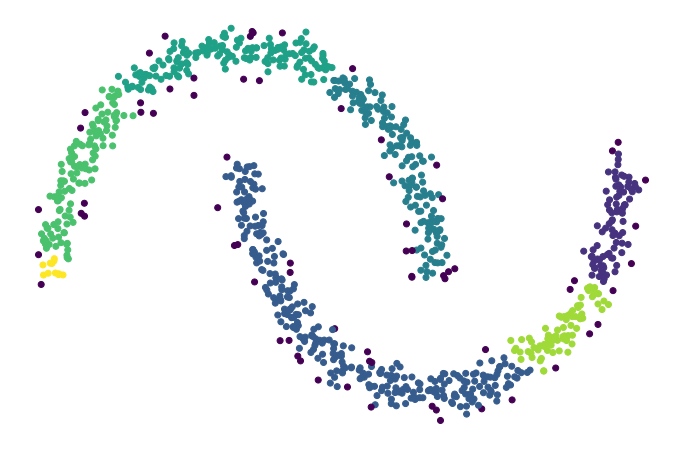

In [88]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_)
plt.axis('off')
plt.show()

- Let's increase $\epsilon$ and replot:

In [89]:
dbscan = DBSCAN(eps=0.2, min_samples=5)

In [90]:
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

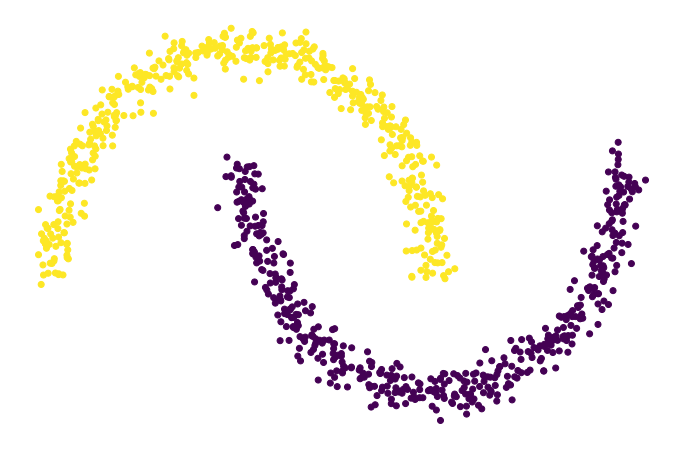

In [91]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_)
plt.axis('off')
plt.show()

- `DBSCAN` doesn't have a `predict()` method for new instances, instead it let's us train a classifier on its training targets to classify new instances.
    - Let's implement if:

In [92]:
from sklearn.neighbors import KNeighborsClassifier

In [93]:
knn = KNeighborsClassifier(n_neighbors=50)

In [94]:
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [95]:
X_new = np.array([[-0.5, 0.], [0, 0.5], [1, -0.1], [2, 1]])

In [96]:
knn.predict(X_new)

array([1, 0, 1, 0])

In [97]:
knn.predict_proba(X_new)

array([[0.14, 0.86],
       [1.  , 0.  ],
       [0.16, 0.84],
       [1.  , 0.  ]])

- Note that we only trained the classifier on the core instances, but we could also have chosen to train it on all the instance, or all but anomalies.
    - It depends on the final task.
- Because we didn't train our classifier on anomalies, any new instance will be put into a cluster.
- It is farily straightforward to introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomaoies.

In [98]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)

In [99]:
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]

In [100]:
y_pred[y_dist > 0.2] = -1

In [101]:
y_pred.ravel()

array([-1,  0,  1, -1])

- In short, `DBSCAN` is a very simple yet powerful algorithm capable of identifying any number of clusters of any shape.
    - It is robust to outliers.
    - It has just two hyper-parameters (`eps` and `min_samples`).
- If the densities vary significantly across the clusters however, It can be impossible for it to capture all the clusters properly.
- Its computational complexity is roughly $O(mlog(m))$ making it pretty close to linear regarding the number of instances.
- But `Sklearn` implementation can require up to $O(m^2)$ in memory if `eps` is large.

### Other Clustering Algorithms

- Agglomerative Clustering
- BIRCH
- Mean-Shift: a complexity of $O(m^2)$
- Affinity Propagation: a complexity of $O(m^2)$
- Spectral clustering: Does not scale well to large number of instances and doesn't behave well when the clusters have very different sizes.

## Gaussian Mixtures

- **A Gaussian Mixture Model (GMM) is a probabilitic model that assumes that the instances were generated from a mixture of several Gaussian distributions whose parameters are unknown**.
- All the instances generated from a single gaussian distribution form a cluster that typically looks like an ellipsoid.
    - Bell, Circle, Ellipsoid.
- Each cluster can have a different ellipsoidal shape, size, density, and orientation.
- When you observe an instance, you know that it was generated from one of the gaussian distributions.
    - But you're not told which one.
    - You do not know the parameters of the generator distribution.
- There are several GMM variants.
    - In the simplest form (implemented in `sklearn`) you must know in advance the number of gaussian distributions.
- The dataset $X$ is assumed to have been generated through the following probabilistic process, Here is a graphical model that represents the structure of the conditional dependencies between the random variables:

<div style="text-align:center">
    <img style="width:50%" src="static/imgs/Gaussian_mixtures.png">
</div>

1. For each instance, A cluster is picked randomly from $k$ clusters
    - The probability of choosing the $j^{th}$ cluster is defined by the cluster's weight, $\phi^{(j)}$
    - The index of the cluster chosen for the $i^{th}$ instance is noted $z^{(i)}$
2. $x^{(i)}$, the location of the instance is sampled randomly from the Gaussian distribution with mean $\mu^{(j)}$ and covariance matrix $\sigma^{(j)}$.
    - Meaning, $x^{(i)} \sim \mathcal{N}(\mu^{(j)}, \sigma^{(j)})$
    
- To understand the figure:
    - squares: constants.
    - rectangle containers: plates, their content is repeated several times.
    - $m,k$: how many times the content is repeated
    - solid arrow: conditional dependency
    - Squishy arrow: A switch

- Given the dataset $X$, you typically want to start by estimating the weights $\phi$ & all the distribution parameters $\mu^{(1)} \dots \mu^{(k)}$ and $\Sigma^{(1)} \dots \Sigma^{(k)}$
- `sklearn` makes this super easy:

In [102]:
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=[0.5, 0.5, 0.5, 1, 1])

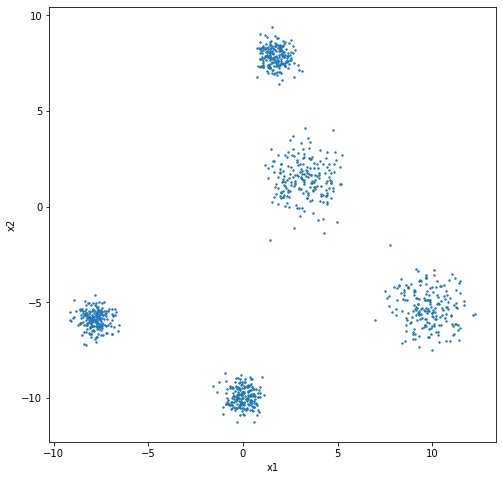

In [103]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [104]:
from sklearn.mixture import GaussianMixture

In [105]:
gm = GaussianMixture(n_components=5, n_init=10)

In [106]:
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [107]:
gm.weights_

array([0.2       , 0.20000006, 0.19999996, 0.2       , 0.19999997])

In [108]:
gm.means_

array([[-0.01956054, -9.92914704],
       [ 3.21215677,  1.44010176],
       [ 9.75080918, -5.26895415],
       [-7.83623486, -5.86560471],
       [ 1.70516646,  7.85434386]])

In [109]:
gm.covariances_

array([[[ 0.24564672, -0.00582069],
        [-0.00582069,  0.24715375]],

       [[ 0.9371689 ,  0.00505178],
        [ 0.00505178,  0.96252823]],

       [[ 0.96136691, -0.11918612],
        [-0.11918612,  0.91842656]],

       [[ 0.25213507, -0.01153816],
        [-0.01153816,  0.22252086]],

       [[ 0.24409886, -0.02429441],
        [-0.02429441,  0.25855108]]])

- But how did it work?
- This class relies on the **expectation maximization (EM)** algorithm.
    - Which has many similarity with the k-means algorithm.
- EM Steps:
    1. Initializes cluster parameters randomly.
    2. Assigns instances to clusters.
    3. Update the clusters.
- You can think of EM as a **generalization** of `KMeans` that not only finds the cluster centers ($\mu^{(1)} \dots \mu^{(k)}$), but also their **size, shape, and orientation** ($\Sigma^{(1)} \dots \Sigma^{(k)}$) as well as their relative sampling weights ($\phi^{(1)} \dots \phi^{(k)}$).
- Unlike `KMeans` though, `EM` uses soft cluster assignments (with probabilities), not hard assignments.
- **During the expectation step**, EM estimates the probability that each instance belongs to each cluster.
- **During the maximization step**, each cluster is updated using all the instances in the dataset.
- Therese probabilities are also called the **responsibilities** of the clusters for the instances.
- You can check if the algorithm converged & how many iterations it took like this:

In [110]:
gm.converged_

True

In [111]:
gm.n_iter_

2

- Let's visualize hard vs. soft clustering with our trained model:

In [112]:
gm.predict(X)[:15]

array([1, 1, 0, 1, 1, 3, 0, 3, 2, 3, 4, 4, 1, 3, 2])

In [113]:
np.round(gm.predict_proba(X)[:15], 5)

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

- A Gaussian Mixture model is a **generative model**, meaning can sample new instances from its source distributions:

In [114]:
X_new, y_new = gm.sample(6)

In [115]:
X_new

array([[  0.39342351,  -9.63370848],
       [  0.6752942 , -10.08668853],
       [ -0.3394771 ,  -9.85565369],
       [  1.80069002,   1.37050469],
       [  4.42993784,   0.14991516],
       [  3.63246716,   3.46972602]])

In [116]:
y_new

array([0, 0, 0, 1, 1, 1])

- It is also possible to estimate the **density** of the model at any given location.
    - The greater the score, the higher the density:

In [117]:
gm.score_samples(X)[:10]

array([-3.87714569, -3.40586787, -3.05168574, -4.90797867, -3.69736342,
       -2.80893491, -2.16715787, -3.94440064, -4.48325493, -2.13425753])

- If you calculate the exponential of these scores, you get the value of the PDF at the location of the given instances.
- The result aren't probabilities but probability densities.
    - If you want the probability that an instance falls within a region, you all to integrate over the region.
- Let's visualize PDF:

In [118]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [119]:
Z = np.exp(gm.score_samples(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

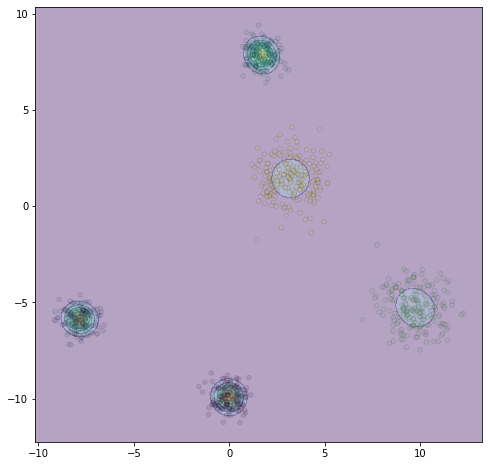

In [120]:
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', alpha=0.1)
plt.show()

- Nice, the algorithm clearly found an excellent solution.
- But it is easy because we generated the data from actual gaussian distributions and gave EM the correct number of clusters.
- When there are many dimensions, or many clusters, or few instances, EM will struggle to converge to the optimal solution.
    - In this case, we need to regularize it.
- One way to do this is to limit the number of shapes and orientations the distributions can take by constraining the space of possible covariance matrices.
- Set the `covariance_type` hyper-parameter to one of the following values:
    - Spherical.
    - Diag.
    - Tied.
- Examples of hyperparameter values over the same dataset:


<div style="text-align:center">
    <img style="width:66%" src="static/imgs/EM_regularization.png">
</div>

- Gaussian Mixture's complexity depends on `m`, `n`, `k` & the constraints over the covariance matrix.
- if contraints fall into `spheric` or `diag`, complexity is $O(kmn)$
- If `tied` or `full`, complexity is $O(kmn^2 + kn^3)$ so it will not scale to large number of features.

### Anomaly Detection using Gaussian Mixtures

- Anomaly detection is the task of detecting instances that deviate strongly from the norm.
    - These instance are called anomalies or outliers, while the rest are called inliers.
- Anomaly detection is useful in a wide range of applications, such as ...
    - Fraud detection
    - Detecting defective products in manufacturing
    - Removing outliers from a dataset before training a model
        - Which can significantly improve the performance of the resulting model.
- In the context of a GMM, any instance located in a low density space region can be considered an anomaly.
- But you must define what density threshold you want to use.
- Here is how you would identify the outliers using the fourth percentile lowest density as the threshold:

In [121]:
densities = gm.score_samples(X)

In [122]:
density_threshold = np.percentile(densities, 4)

In [123]:
anomalies = X[densities < density_threshold]

In [124]:
anomalies.shape

(40, 2)

- A closely related task is **novelty detection**, it differs from anomaly detection in that the algorithm is assumed to be trained on a clear dataset.
    - Meaning whatever special instances you find, they are not anomalies but rather rare novelties.
- Just like `KMeans`, the `GaussianMixture` algorithm requires you to specify the number of clusters. So how can you find it? 

### Selecting the Number of Clusters

- We can try to find the model that **minimizes a theoretical information criterion**, such as ..
    - the **Bayesian information criterion (BIC)**
    - **Akaike information criterion (AIC)**.

$$BIC = log(m)p - 2log(\hat{L}) \\ AIC = 2p - 2log(\hat{L})$$

- $m$ is the number of instances.
- $p$ is the number of parameters learned by the model.
- $\hat{L}$ is the maximized value of the likelihood function of the model.
- BIC and AIC tend to penalize models that have more parameters to learn (e.g. more clusters)
- They also reward models that fit the data well.
- They often endup selecting the same model.
- When they differ, the model selected by BIC tends to be simpler than the one selected by AIC, but tends to not fit the data quite as well.
- The difference between probability & likelihood: Given a statistical model with parameters $\theta$ ($M_{\theta}$)
    - Probability of an outcome $x$ given the model's parameters $\theta$ is: $P_{\theta}(X=x)$.
    - Likelihood of $\theta=\phi$ given $X=x$ is: $P_{X=x}(\theta=\phi)$.
- So:

$$\hat{L}=max_{\phi}\{P_{X=x}(\theta=\phi)\} \\ \hat{L}=max_{\phi}f(\theta=\phi;X)$$

- The PDF is a function of $x$ while $\theta$ is fixed.
- The likelihood is a function of $\theta$ while $x$ is fixed.
- It is important to understand that the likelihood function **is not a probability distribution**.
- Given a dataset $X$, a **common task is to try to estimate the most likely values for the model parameters**.
    - To do this, you must find $\theta$ that maximizes the likelihood function, given $X$.
- **Maximum a-posterior estimation**: When we have a prior probability distribution over $\theta$ ($g(\theta)$), it is possible to take it into account by maximizing $\mathscr{L}(\theta|x)g(\theta)$ instead of $\mathscr{L}(\theta|x)$.
- Because $log$ is increasing, maximizing the likelihood function is equivalent to maximizing its log.
    - It is generally easier to maximize the log likelihood.
        - Because if you observed several instances, you would need to maximize the likelihood of the product that consists of all instances.
        - But because $log(ab)=log(a)+log(b)$, maximizing sums is easier.
- Once we find $\hat{\theta}$ that maximizes the likelihood function, then we compute $\hat{L}=\mathscr{L}(\hat{\theta},X)$ which is what we need for AIC & BIC.
- Let's do it in `sklearn`:

In [125]:
gm.bic(X)

7354.722097547833

In [126]:
gm.aic(X)

7212.397194457351

- The following figure shows the values of BIC & AIC for different cluster numbers:

<div style="text-align:center">
    <img style="width:66%" src="static/imgs/AIC_BIC.png">
</div>

- As we can see, AIC & BIC are lowest when $k=3$ so it is most likely the best choice.

### Bayesian Gaussian Mixture Models

- Rather than manually searching for the optimal number of clusters, you can use the `BayesianGaussianMixture` class.
    - Which is capable of giving weights equal (or close) to zero to unnecessary clusters.
- For example, let's set the number of clusters to 10 and see what happens:

In [127]:
from sklearn.mixture import BayesianGaussianMixture

In [128]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10)

In [129]:
bgm.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=None, reg_covar=1e-06, tol=0.001,
                        verbose=0, verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [130]:
np.round(bgm.weights_, 2)

array([0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ])

- The algorithm automatically detected that only $5$ clusters are needed.
- In this model, the cluster parameters (weights, means, co-variance matrices) are not treated as fixed model parameters anymore, but as latent random variables.
    - Like the cluster assignments.
- So $z$ now includes both cluster parameters & cluster assignments.
- The beta distribution is commonly used to model random variables whose values lie within a fixed range.
    - In this case, the range is from $0$ to $1$.
- The stick-breaking process is a good model for datasets where new instances are more likely to join large clusters than small clusters.
    - E.g. people love to move to larger cities.
- **If the concentration $\alpha$ is high, then $\phi$ values will likely be close to 0, and the SBP will generate more clusters**.
- The wishard distribution is used to sample covariance matrices, the parameters $d$ and $V$ control the distribution of cluster shapes.

<div style="text-align:center">
    <img style="width:50%" src="static/imgs/BGMM.png">
</div>

- Prior knowledge about the latent variables $z$ can be encoded in a probability distribution $p(z)$ called the *prior*.
    - For example, we may have a prior belief that the clusters are likely to be few.
        - Low concentration
- **The more data we have, the more the prior matters**.
- Bayes' theorem tells us how to update the probability distribution over the latent variables after we observe some data $X$.
    - **It computes the posterior distribution $p(z|X)$, which is the conditional probability of $z$ given $X$**.

$$P(z|X)=\frac{P(X|z)P(z)}{P(X)}$$

- The evidence $P(X)$ is often intractable:

$$P(X)=\int P(X|z)P(z)dz$$

- This intractability is one of the central problems is Bayesian Statistics, and there are several approaches to solving it.
- One of them is **variational inference**.
    - Picks a famility of distributions $q(z;\lambda)$ ($\lambda$: variational parameter).
    - Then optimizes these parameters to make $q(z) \approx p(z|X)$.
    - This is achieved by finding $\lambda$ that minimizes the KL divergence between $q(z)$ and $p(z|X)$.
        - Noted $D_{KL}(q||p)$.
- The KL equation can be re-written as the log of the evidence minus the evidence lower bound (ELBO).

$$D_{KL}(q||p)=log p(X) - ELBO$$

- Since the log of the evidence doesn't depend on $q$, minimizing KL divergence is equivalent to minimizing the ELBO expression.
- In practice, there are different techniques to minimizing the ELBO.
- In mean field variational inference, it is necessary to pick a family of distributions $q(z;\lambda)$ and the prior $p(z)$ very carefully to ensure that the equation for the ELBO simplifies to a form that can be computed.
    - Unfortunately, there is no general way to do this.
- An opproach to maximizing the ELBO is called *black box stochastic variational inference (BBSVI)*:
    - At each iteration a few samples are drawn from $q$ and they're used to estimate the gradients of the ELBO with regards to the variational parameters of $\lambda$.
    - Which are then used in a gradient ascent step.
- This approach makes it possible to use Bayesian inference with any differentiable system, even deep neural networks.
    - Called **Bayesian Deep Learning**.
- Now let's take a look at other algorithms capable of dealing with arbitrary cluster shapes.

### Other Algorithms for Anomaly & Novelty Detection

- PCA
    - If you compare the reconstruction error of a normal instance versus the reconstruction error of an anomaly, the latter will be greater.
- Fast-MCD
    - It assumes that normal instances are generated from a single gaussian distribution, and is good at ignoring the others.
- Isolation Forest
    - Uses random forest to split instances into groups and isolate the outliers randomly.
- Local Outlier Factor
    - It compares the density around an instance to the densities around its neighbors.
        - An anomaly is often isolated in comparison to its neighbors.
- One-class SVM
    - It tries to seperate the instances in high-dimensional space from the **origin**, hence creating a small region that compasses all in the low-dim space.
        - If a new instance doesn't fall within this region, It is an anomaly.

---

# Exercices

**1. How would you define clustering? Can you name a few clustering algorithms?**
- Clustering is the process of uncovering groups (or clusters) within unlabaeled data instances.
- Algorithms: `KMeans`, `DBSCAN`, `GMMs`, ...

**2. What are some of the main applications of clustering algorithms?**
- Customer Segmentation, Fraud Detection, Novelty Detection, Social Networks Analysis (Communities) ...

**3. Describe 2 techniques to select the right number of clusters when using K-Means?**
- Plotting the `silouhette` density score in relation to the chosen number of clusters then choosing the number of clusters that maximizes the score.
- By choosing the number of clusters that decreased the inretia the most.

**4. What is label propagation? Why would you implement it? and How?**
- Label propagation is useful in the context of semi-supervised learning where we have a few labeled points and a lot of unlabeled instances and we want to propagate the labels from the annotated samples to the unlabeled ones.
- We would want to to implement it if we have a downstream supervised learning task that needs more data.
- A simple strategy would be distance-based propagation, where first we will train an algorithm to do unsupervised clustering and then propagate the labels into the ones that correspond to the same clusters of the annotated instances.

**5. Can you name two clustering algorithms that can scale to large datasets? and two that look for regions of high density?**

- `DBSCAN` (if $\epsilon$ is small enough), and `KMeans` (if dataset is comprised of clusters).
- `DBSCAN` and `Gaussian Mixture Models`.

**6. Can you think of a use case when active learning would be useful? How would you implement it?**

- It would be useful when we're having a small labeled dataset and a lot of unlabeled instances.
- First we train the algorithm of the available labeled instances. Then we predict on the unlabeled instances and give the annotator the instances that the algorithm isn't sure about. We loop until the increase in performance in not noticeable anymore.

**7. What is the difference between Anomaly Detection & Novelty Detection?**

- Anomaly Detection: Detecting instances that don't belong to the same data distribution of the training data.
- Novelty Detection: Detecting instances that look extreme but belong to the same distribution of the training data.

**8. What is a Gaussian Mixture? What Tasks can you use it for?**

- Gaussian Mixture is comprised of multiple gaussian distributions with multiple parameters ($\mu$ and $\sigma$) and a set of weights ($\phi$) that describe the probability that an instance belongs to one of the distributions.
- In our case, it was used to uncover clusters in unlabeled data assuming that all of the clusters correspond to gaussian distributions.

**9. Can you find two techniques to find the right number of clusters when using a Gaussian mixture model?**

- Using the expectation maximization (EM) algorithm that generalizes the optimization porcess used by `KMeans`.
- Using Bayesian Gaussian Mixture Models to avoid random search and using priors instead.

**10. The classic Olivetti faces dataset contains 400 gray-scale $64 \times 64$-pixel images of faces. Each image is flattened to a 1D vector of size $4,096$. 40 different people were photographed (10 times each), and the usual task is to train a model to predict which person is represented in each picture. Load the dataset using `sklearn.datasets.fetch_olivetti_faces()` function, then split it into training/validation and test set. Since the dataset is quite small, you probability want to use stratefied sampling to ensure that there are the same number of images per person in each set** 

In [151]:
of = datasets.fetch_olivetti_faces()

In [152]:
X, y = of.data, of.target
X.shape, y.shape

((400, 4096), (400,))

In [153]:
from sklearn.model_selection import train_test_split

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [155]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train)

In [156]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((225, 4096), (225,), (75, 4096), (75,), (100, 4096), (100,))

**Cluster the images using `KMeans`, and measure that you have a good number of clusters. Visualize the clusters: do you see similar faces in each cluster?**

In [161]:
kms = KMeans()

In [162]:
kms.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
inretias = list()
for k in range(1, 100):
    kms = KMeans(n_clusters=k)
    kms.fit(X_train)
    inretias.append(kms.inertia_)

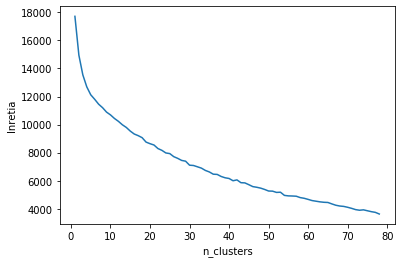

In [168]:
plt.plot(range(1, 79), inretias)
plt.xlabel('n_clusters')
plt.ylabel('Inretia')
plt.show()

Can't really get anything from the previous visualization.

In [170]:
s_scores = list()
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    s_scores.append(silhouette_score(X_train, kmeans.labels_))
    del(kmeans)

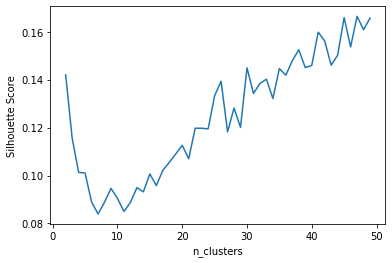

In [171]:
plt.plot(range(2, 50), s_scores)
plt.xlabel('n_clusters')
plt.ylabel('Silhouette Score')
plt.show()